In [1]:
import numpy as np
import torch
from datetime import datetime
import glob
import os
import math

import objectives
import utils

from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [ ]:
# fold = sorted([os.path.basename(n[:-1]) for n in glob.glob('/scratch/ml/jbowden/results/*/')])
# print(fold)

In [3]:
subdir = '12-20/test_da3_ll'
subdir = 'older/mr1'
subdir = '01-21/test_mf_sf'
print(subdir)

01-21/test_mf_sf


In [4]:
tensors = sorted(glob.glob('/scratch/ml/jbowden/results/' + subdir + '/*.pt'))
# print(tensors)
# [print(t.split('/')[-1].split('regret')[0]) for t in tensors if 'regret' in t]
# name : (dtype:tensor)
tests = {}
# assuming not getting models out
for tensor in tensors:
#     if 'EGrbf' in tensor or 'TSrbf' in tensor or 'EGlin' in tensor:
#         continue
    if '.pt' in tensor and 'state_dict' not in tensor:
#         if '22' in tensor:
#             print(tensor)
#             continue
        first = False
        nm = os.path.basename(tensor).split('_')[0]
        t = torch.load(tensor).cpu().detach()
        t = torch.reshape(t, (1, -1))
#         print(tensor)
#         print(t.size(-1))
        lim = 000
#         lim = 1000
        rand = 10
#         if 'regret.pt' in tensor and int(tensor.split('_')[-1].split('regret')[0]) > 15:
#             print(tensor)
#             continue
        if ('y.pt' in tensor and t.size(-1) < lim + rand) or ('y.pt' not in tensor and t.size(-1) < lim):
            if 'regret.pt' in tensor:
                print(tensor)
#                 print(tensor.split('regret.pt')[0].split('/')[-1])
            continue
        if nm in tests.keys():
            d = tests[nm]
        else:
            d = {}
            tests[nm] = d
        dtype = os.path.basename(tensor).split('_')[-1].split('.')[0]
        dtype = ''.join([i for i in dtype if not i.isdigit()])
        if dtype in d.keys():
            arr = d[dtype]
        else:
            arr = t
            d[dtype] = arr
            first = True
        if first:
            pass
        elif t.size(-1) < arr.size(-1):
#             arr = torch.cat((arr[t.size(-1)], t), 0)
            arr = torch.cat((arr[:,:t.size(-1)], t), 0)
        else:
            arr = torch.cat((arr, t[:,:arr.size(-1)]), 0)
#             arr = torch.cat((arr, t[arr.size(-1)]), 0)
#         arr = torch.cat((arr, t), 0)
#         print(arr)
#         print(t)
        d[dtype] = arr
        tests[nm] = d
# print(tests)
# aggreggate data
# dtype: (name:tensor)
batch = {}
budget, total= math.inf, math.inf
for key in tests.keys():
    print(key)
    for dtype in tests[key].keys():
#         print(dtype)
        t = tests[key][dtype]
#         print(t.size())
        if 'regret' == dtype and t.size(-1) < budget and t.size(-1) != 0:
#             print(dtype)
            budget = t.size(-1)
            num_runs = t.size(0)
        elif 'y' in dtype and t.size(-1) < total and t.size(-1) != 0:
            total = t.size(-1)
        sd, mean = torch.std_mean(t, 0)
#         print(sd)
#         print((t.size(0)**.5))
        sem = sd / (t.size(0)**.5)
        if dtype in batch.keys():
            d = batch[dtype]
        else:
            d = {}
            batch[dtype] = d
        d[key] = (mean, sem)
        batch[dtype] = d
    print("Runs: {}".format(num_runs))
print(batch.keys())
# runs = int(len(tensors)/(7 * (len(tests) - 1)))
# print('Avg runs: {}'.format(runs))
print('Budget: {}'.format(budget))
print('Total queries (incl. init): {}'.format(total))

DKL-50Lin-TS
Runs: 8
DKL-50Lin-UCB
Runs: 8
DKL-50MCD-0.3-Lin-TS
Runs: 8
DKL-50MCD-0.3-Lin-UCB
Runs: 8
GP-Lin-TS
Runs: 8
GP-Lin-UCB
Runs: 8
Random
Runs: 8
dict_keys(['ll', 'regret', 'x', 'norm', 'y'])
Budget: 181
Total queries (incl. init): 190


DKL-50Lin-TS
tensor(15.6868)
DKL-50Lin-UCB
tensor(24.8544)
DKL-50MCD-0.3-Lin-TS
tensor(23.6427)
DKL-50MCD-0.3-Lin-UCB
tensor(30.4927)
GP-Lin-TS
tensor(38.0268)
GP-Lin-UCB
tensor(55.6970)
Random
301
tensor(51.3511)


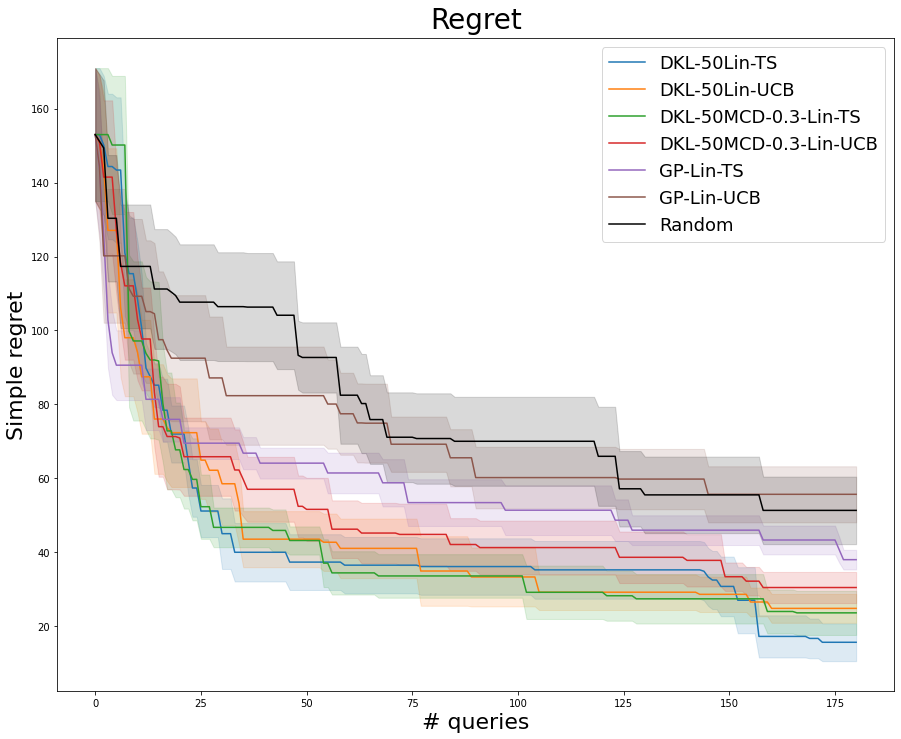

In [5]:
def plot_regret(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 12))
    names = []
    queries = np.arange(budget)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
        plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
        print(name)
#         if '58' in name:
#             continue
#         if '176' not in name and 'GP' not in name:
#             continue
#         if name != 'DKL-58MCD-0.3-Lin-TS' and name != 'GP-Lin-UCB':
#             continue
#         if name != 'DKL-MCD-0.2-RBF-UCB' and name != 'GP-Lin-UCB':# and 'Random' not in name:
#         if 'TS' not in name:# or 'EG' in name: #and 'Random' not in name:
#             continue
        names.append(name)
        mean, sem = tests[name]
        if mean.size(0) < budget:
            print(mean.size(0))
            names.pop()
            continue
        if mean.size(0) > budget:
#             print(name)
            print(mean.size(-1))
            mean = mean[:budget]
            sem = sem[:budget]
        if 'Random' in name:
            p = plt.plot(queries, mean, color='black')
            plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, mean)
            plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
        print(mean[-1])
#     plt.rcParams.update({'font.size': 22})
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.ylabel('Simple regret', fontsize=22)
    plt.xlabel('# queries', fontsize=22)
    plt.legend(names, loc='upper right', fontsize=18)
#     plt.title('Regret: GB1', pad=10, fontsize=28)
    plt.title('Regret', pad=10, fontsize=28)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
plot_regret(batch['regret'], budget, randregret=None)

In [48]:
batch['ll']

{'DKL-50Lin-TS': (tensor([0.4355, 0.4246, 0.4196, 0.4145, 0.4097, 0.4057, 0.4017, 0.3969, 0.3957,
          0.3931, 0.3905, 0.3890, 0.3869, 0.3847, 0.3821, 0.3806, 0.3795, 0.3774,
          0.3748, 0.3735, 0.3718, 0.3709, 0.3700, 0.3689, 0.3679, 0.3674, 0.3661,
          0.3642, 0.3634, 0.3637, 0.3621, 0.3611, 0.3624, 0.3606, 0.3591, 0.3592,
          0.3603, 0.3570, 0.3588, 0.3567, 0.3563, 0.3585, 0.3576, 0.3588, 0.3553,
          0.3526, 0.3527, 0.3528, 0.3527, 0.3518, 0.3516, 0.3509, 0.3497, 0.3506,
          0.3500, 0.3497, 0.3494, 0.3499, 0.3485, 0.3507, 0.3476, 0.3493, 0.3475,
          0.3483, 0.3509, 0.3484, 0.3474, 0.3473, 0.3502, 0.3474, 0.3485, 0.3476,
          0.3473, 0.3451, 0.3475, 0.3486, 0.3451, 0.3455, 0.3465, 0.3454, 0.3455,
          0.3481, 0.3459, 0.3475, 0.3454, 0.3484, 0.3444, 0.3461, 0.3437, 0.3444,
          0.3442, 0.3246, 0.3742, 0.3721, 0.3764, 0.3780, 0.3702, 0.3694, 0.3682,
          0.3763, 0.3763, 0.3790, 0.3788, 0.3766, 0.3769, 0.3727, 0.3783, 0.3695,


DKL-50Lin-TS
301
tensor(0.3690, dtype=torch.float64)
DKL-50Lin-UCB
301
tensor(0.3718, dtype=torch.float64)
DKL-50MCD-0.3-Lin-TS
301
tensor(0.3701, dtype=torch.float64)
DKL-50MCD-0.3-Lin-UCB
301
tensor(0.3800, dtype=torch.float64)


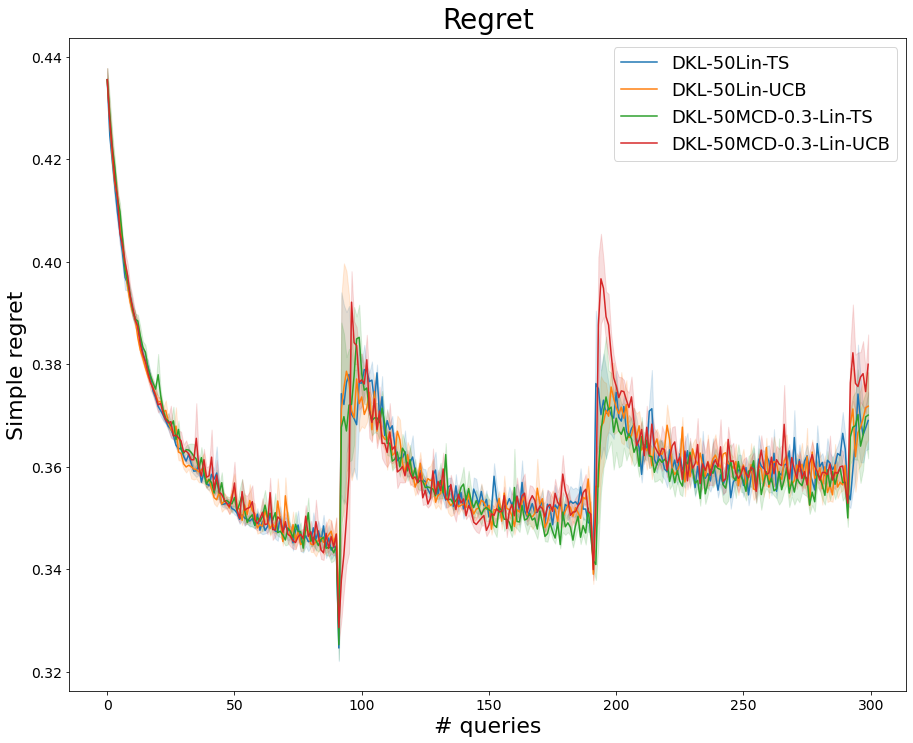

In [49]:
plot_regret(batch['ll'], budget-1, randregret=None)

In [24]:
def plot_mae(train, budget, test=None):
    '''Pass in list of bo objects and labels.'''
    # train, test is name:(mean, sem)
    mx, mn = 0, 1
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    # should be same names
    for name in sorted(train.keys()):
#         if '2500' not in name and 'GP' not in name:
#             continue
        mean, sem = train[name]
        print(name)
#         print(mean)
        names.append(name + ' (train)')
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                mean = mean[:budget]
                sem = sem[:budget]
        p = plt.plot(queries, mean)
        plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
        if test != None:
            mean, sem = test[name]
#             print(mean)
            if mean.size(0) > budget:
                mean = mean[:budget]
                sem = sem[:budget]
            p = plt.plot(queries, mean, color=p[-1].get_color(), linestyle='dotted')
            names.append(name + ' (test)')
            plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
        print(mean[-1])
        h, l = max(mean), min(mean)
        if h > mx:
            mx = h
        if l < mn:
            mn = l
    print("test: min {}, max {}, range {}".format(mn, mx, mx-mn))
    plt.ylabel('MAE', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.title('MAE:', pad=10, fontsize=20)
    plt.legend(names)
    plt.show()
    
%matplotlib inline
# skip objective
# plot_mae(batch['ratrainmae'], budget, test=batch['ratestmae'])

In [3]:
def batch_distances(x, batch_size):
    ind = 0
    distances = []
    for i in range(0, x.size(0), batch_size):
        total = 0
        for j in range(i, i + batch_size):
            curr = x[j]
            for k in range(j, i + batch_size):
                total += torch.sum(torch.abs((curr - x[k])**2)).item()**.5
        distances.append(total)
    return distances

def calc_distance(x):
    total = 0
    for i in range(x.size(0)):
        curr = x[i]
        for j in range(i, x.size(0)):
            total += torch.sum(torch.abs((curr - x[j])**2)).item()**.5
    return total/x.size(0)

def calc_distances(filenames, batch=5):
    fig = plt.figure(figsize=(15, 12))
    for fname in filenames:
        print(fname.split('/')[-1])
        x = torch.load(fname + 'x.pt')
        y = torch.load(fname + 'y.pt')
        axis = torch.Tensor(range(int(x.size(0)/batch)))
        print(calc_distance(x))
        print(calc_distance(y))
        plt.plot(axis, batch_distances(x, batch))
        plt.plot(axis, batch_distances(y, batch))
    plt.legend([f.split('/')[-1] for f in filenames])
    plt.yscale('log')
    plt.show()

DKL-10Lin-UCB
tensor(6.7698)
DKL-10MCD-0.2-Lin-TS
tensor(7.4796)
DKL-25Lin-UCB
tensor(7.8661)
DKL-25MCD-0.2-Lin-TS
tensor(8.3511)
DKL-2Lin-UCB
tensor(7.5670)
DKL-2MCD-0.2-Lin-TS
tensor(7.8169)
DKL-58Lin-UCB
tensor(6.7115)
DKL-58MCD-0.2-Lin-TS
tensor(8.1235)
GP-Lin-UCB
tensor(7.3936)
Random
tensor(3.6990)


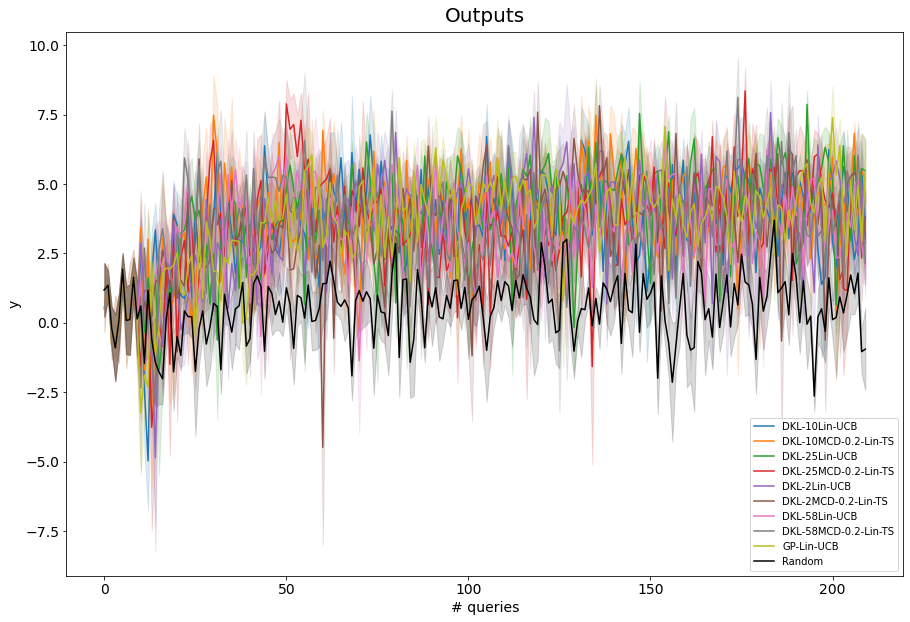

In [90]:
def plot_y(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
        plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
#         if 'TS' not in name:
#             continue
        print(name)
#         if '2500' not in name and 'GP' not in name:
#             continue
        names.append(name)
        mean, sem = tests[name]
        print(torch.max(mean))
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                print(mean.size(-1))
                mean = mean[:budget]
                sem = sem[:budget]
        reg = []
        for i in range(budget):
            reg.append(torch.max(mean[:i+1]))
        if 'Random' in name:
            p = plt.plot(queries, mean, color='black')
            plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, mean)
            plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
plot_y(batch['y'], total, randregret=None)

210
210
210
210
210
210
210
210
210
210


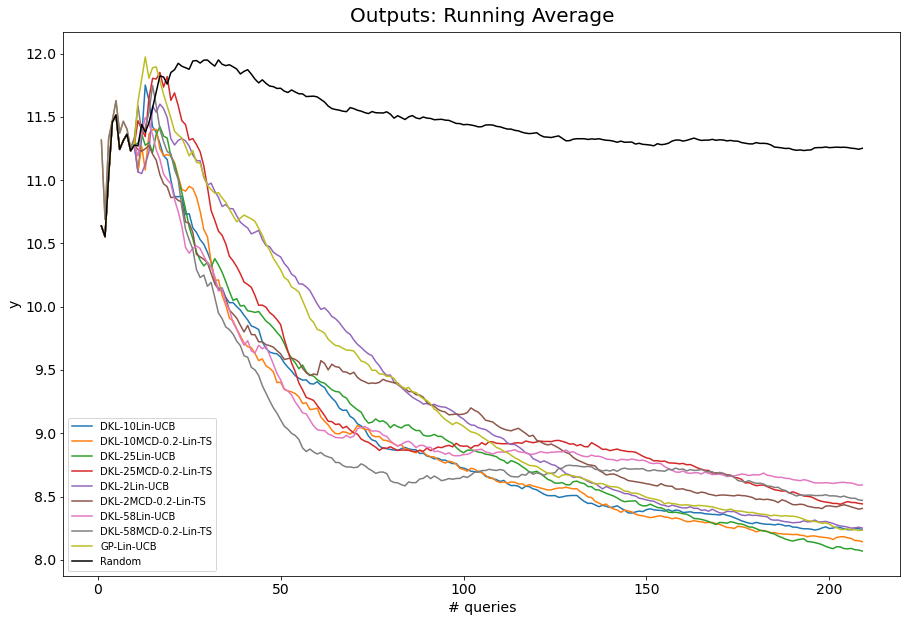

In [92]:
def plot_yavg(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget + 1)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
#         plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
#         if '2500' not in name and 'GP' not in name:
#             continue
        names.append(name)
        obj_max = objectives.Proteins_td.get_max()
        mean, sem = tests[name]
        mean = obj_max - mean
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                print(mean.size(-1))
                mean = mean[mean.size(0) - budget - 1:]
                sem = sem[mean.size(0) - budget:]
        running = []
        for y in range(mean.size(-1)):
            running.append(torch.reshape(torch.mean(mean[:y]), (1,1)))
        running = torch.cat(running, 0)
        if 'Random' in name:
            p = plt.plot(queries, running, color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, running)
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Running Average', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
plot_yavg(batch['y'], total-1, randregret=None)

In [75]:
# print(tests)
def get_individ(name):
    individ = []
    for key in tests.keys():
        ind = 0
        if name == 'acq' and 'Random' in key:
            continue
        for run in tests[key][name]:
            try:
                arr = individ[ind]
            except:
                arr = {}
                individ.append(arr)
            arr[key] = run
            individ[ind] = arr
            ind += 1
    return individ

In [76]:
ind_y = get_individ('y')
ind_acq = get_individ('acq')

In [72]:
def plot_ind(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    for name in sorted(tests.keys()):
        names.append(name)
        y = tests[name]
#          or 'DKL' in name
        if y.size(0) < budget:
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        if 'Random' in name:
            p = plt.plot(queries, y.detach().numpy(), color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, y.detach().numpy())
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Individual Run', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()

In [ ]:
def plot_two(tests1, tests2, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    for name in sorted(tests1.keys()):
        names.append(name + 'y')
        y = tests1[name]
#          or 'DKL' in name
        if 'Random' in name or y.size(0) < budget:
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        p = plt.plot(queries, y.detach().numpy())
    for name in sorted(tests2.keys()):
        names.append(name + 'acq')
        y = tests2[name]
#          or 'DKL' in name
        if 'Random' in name or y.size(0) < budget:
            print(y.size(0))
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        p = plt.plot(queries, y.detach().numpy())
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Individual Run', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()

In [ ]:
# for run1, run2 in zip(ind_y, ind_acq):
#     plot_two(run1, run2, total - 1)

In [ ]:
def plot_cum(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    for name in sorted(tests.keys()):
        names.append(name)
        y = tests[name]
#          or 'DKL' in name
        if y.size(0) < budget:
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        if 'Random' in name:
            p = plt.plot(queries, y.detach().numpy(), color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, y.detach().numpy())
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Individual Run', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()

In [77]:
regs = {}
obj_max = objectives.Proteins_td.get_max()
for run in ind_y:
    for m in run.keys():
        reg = []
        for i in range(run[m].size(-1)):
            s = 0
            for j in range(0, i + 1):
                s += (obj_max - run[m][j])
#             reg.append(s / (i+1))
            reg.append(torch.reshape(s/(i+1), (1, 1)))
        if m not in regs.keys():
            arr = []
        else:
            arr = regs[m]
        arr.append(torch.cat(reg, -1))
        regs[m] = arr
    

# print(regs)                
#     print(run)
#     plot_cum(run, budget)

[]


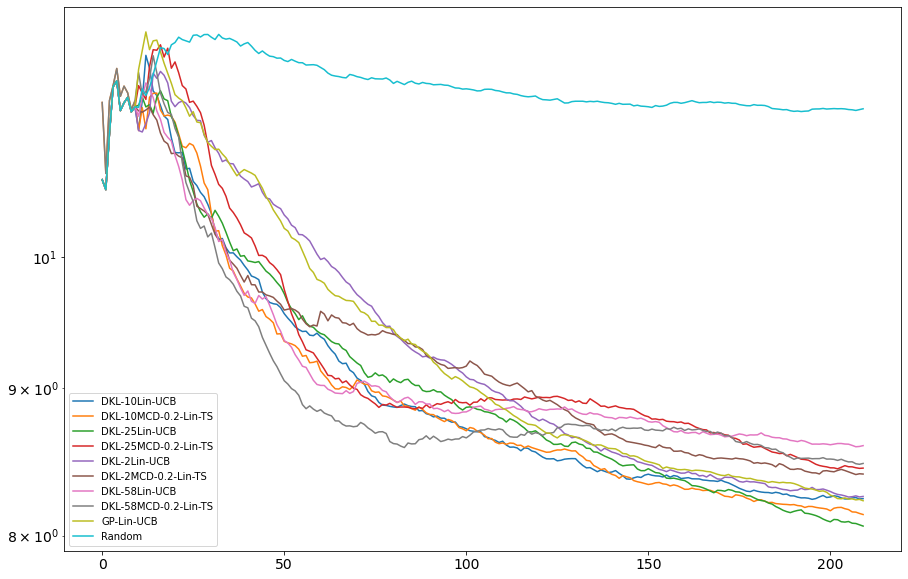

In [89]:
fig = plt.figure(figsize=(15, 10))
queries = np.arange(budget + 9)
cum_arr = []
names = sorted(regs.keys())
for key in names:
    t = torch.cat(regs[key], 0)
    sd, mean = torch.std_mean(t, 0)
    p = plt.plot(queries, mean)
#     plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    
#     s = 0
#     for t in regs[key]:
#         s += t
#     cum_arr.append(s / len(regs[key]))
    
print(cum_arr)
plt.legend(names)
# plt.yscale('log')
plt.show()

In [ ]:
# for run in ind_acq:
#     plot_ind(run, budget - 1)

In [ ]:
# subdir = 'trashlc2'
lcnames = glob.glob('data/' + subdir + '/*lc.pt') + glob.glob('data/' + subdir + '/*loss.pt')
# print(lcnames)
for name in sorted(lcnames):
    if '23' in name:
        continue
    fig = plt.figure(figsize=(6, 4))
    print(os.path.basename(name))
    t = torch.load(name)
    queries = list(range(t.size(-1)))
    for curve in range(t.size(0)):
        plt.plot(queries, t[curve])
    plt.legend(list(range(t.size(0))))
    plt.show()
#     print(t)

In [34]:
# plots regret of average y (not entirely accurate)
def plot_y(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
        plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
        print(name)
#         if '2500' not in name and 'GP' not in name:
#             continue
        names.append(name)
        mean, sem = tests[name]
        print(torch.max(mean))
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                print(mean.size(-1))
                mean = mean[:budget]
                sem = sem[:budget]
        reg = []
        for i in range(budget):
            reg.append(torch.max(mean[:i+1]))
        if 'Random' in name:
            p = plt.plot(queries, reg, color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, reg)
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
# plot_y(batch['y'], total, randregret=None)

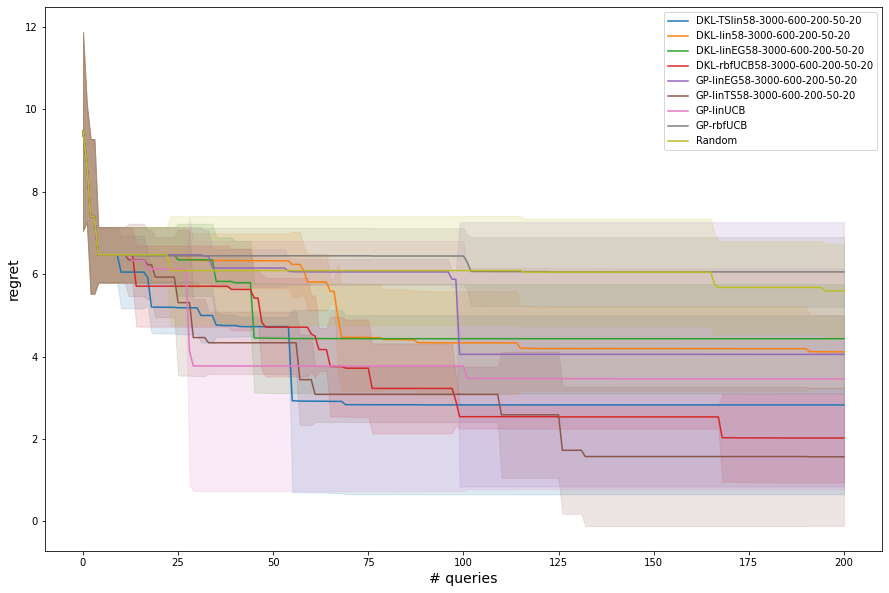

In [92]:
# flips y graph to match regret->0
# regrets = []
# ys = {}
# for run in ind_y:
#     for key in run.keys():
#         if key in ys:
#             arr = ys[key]
#             arr.append(run[key])
#             ys[key] = arr
#         else:
#             ys[key] = [run[key]]
# for key in ys.keys():
#     ind_regs = []
#     for t in ys[key]:
#         reg = []
#         for i in range(t.size(-1)):
#             reg.append(torch.reshape(torch.max(t[:i+1]), (1, -1)))
#         ind_regs.append(torch.cat(reg, -1))
# #     avg_reg = 0
# #     count = 0
# #     for reg in ind_regs:
# #         avg_reg += reg
# #         count += 1
# #     avg_reg /= count
#     sd, mean = torch.std_mean(torch.cat(ind_regs, 0), 0)
#     regrets.append((key, sd, mean))
# fig = plt.figure(figsize=(15, 10))
# names = []
# queries = np.arange(budget)
# for key, sd, mean in regrets:
#     if mean.size(0) > budget:
# #         print(mean.size(-1))
#         mean = 11.8260 - mean[:budget]
#         sd = sd[:budget]
#     names.append(key)
#     p = plt.plot(queries, mean.detach().numpy())
#     plt.fill_between(queries, mean - sd, mean + sd, color=p[-1].get_color(), alpha=.15)
# plt.ylabel('regret', fontsize=14)
# plt.xlabel('# queries', fontsize=14)
# plt.legend(names)

In [1]:
lst = [1,2,3,4,5]
lst2 = lst
lst2.reverse()
print(lst)
print(lst2)

[5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
